In [0]:
# Taken from https://github.com/seyrankhademi/ResNet_CIFAR10
import os
from google.colab import drive
drive.mount('/content/gdrive')
# Here specify the path to your directory
!ls "/content/gdrive/My Drive/DeepLearning" 
root_path = 'gdrive/My Drive/DeepLearning' 
path ='/content/gdrive/My Drive/DeepLearning'
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 BatchNormalisation.ipynb
 clip_figure1.PNG
 cnn_accuracies.png
 Comparison_activations.png
 Comparison_lrs.png
 data
'ffn_BN_accuracy_97.55_lr=0.005_20200419'
'ffn_NO_BN_accuracy_96.71_lr=0.005_20200419'
'ffn_NO_BN_accuracy_97.99_lr=0.005_20200419'
 figure1.PNG
 FromScratch.ipynb
 MNIST
 percentile_cnn_BN.png
 percentile_cnn_NO_BN.png
 percentile_ffn_BN.png
 percentile_ffn_NO_BN.png
 random_neuron_percentile_BN.png
 random_neuron_percentile_NO_BN.png
 Scratch_Accuracy_LR0-1_init1.png
 Scratch_Accuracy_LR0-1.png
 Scratch_ActivationsBN_LR0-1_init1.png
 Scratch_ActivationsBN_LR0-1.png
 Scratch_ActivationsNoBN_LR0-1_init1.png
 Scratch_ActivationsNoBN_LR0-1.png
 Trained_Models


In [0]:
import torch 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import numpy as np
torch.manual_seed(1)

#Adapted from https://deepnotes.io/softmax-crossentropy
def stable_softmax(X):
    maximums = torch.max(X, 1)[0]
    exps = torch.exp(X - maximums.reshape(maximums.shape[0],1))
    sums = torch.sum(exps, 1) 
    return exps / sums.reshape(sums.shape[0],1)

def cross_entropy(X,y):
    """
    X is the output from fully connected layer (num_examples x num_classes)
    y is labels (num_examples x 1)
    	Note that y is not one-hot encoded vector. 
    	It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
    """

    m = y.shape[0]
    p = stable_softmax(X)
    oneHot = torch.zeros((N, D_out), device=device, dtype=dtype)
    oneHot.zero_()
    oneHot.scatter_(1, y, 1)
    new_log_likelihood = - oneHot * torch.log(p)
    loss = torch.sum(new_log_likelihood) / m
    return loss

dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose( [transforms.ToTensor()] )                          
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=60,     
                                          shuffle=True, num_workers=1)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=60,
                                         shuffle=False, num_workers=1)

# Whole training set to compute statistics to use during testing
wholeBatch = torch.empty(60_000, 28*28, device=device, dtype=dtype)

for i, batch in enumerate(trainloader):
  wholeBatch[i*60:(i+1)*60, :] = batch[0].view(60, 28*28)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [0]:
# Adapted from https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 60, 28*28, 100, 10

# Create random Tensors to hold input and outputs.

# One hot vector with the target labels for testing
y_onehot = torch.zeros(N, D_out, dtype=dtype, device=device)

# weigths and biases
w0 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=False) #* 0.1
w1 = torch.randn(H, H, device=device, dtype=dtype, requires_grad=False)    #* 0.1
w2 = torch.randn(H, H, device=device, dtype=dtype, requires_grad=False)    #* 0.1
wy = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=False)#* 0.1
b0 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)    #* 0.1
b1 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)    #* 0.1
b2 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)    #* 0.1
by = torch.randn(1, D_out, device=device, dtype=dtype, requires_grad=False)#* 0.1

# vectors to create matrices with repeating rows. Used for bias, gamma and beta
ones = torch.ones(N, 1)
# vector to stabilize dividing by sqrt(var)
eps = torch.zeros((1, H), device=device)+1e-8

## bb = beta, gg = gamma from the BN in the different layers
gg0 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)   #* 0.1
bb0 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)   #* 0.1
gg1 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)   #* 0.1
bb1 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)   #* 0.1
gg2 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)   #* 0.1
bb2 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)   #* 0.1

#variables for momentum
momentum = 0.9

vwy  = 0
vby  = 0
vgg2 = 0
vbb2 = 0
vw2  = 0
vb2  = 0
vgg1 = 0
vbb1 = 0
vw1  = 0
vb1  = 0
vgg0 = 0
vbb0 = 0
vw0  = 0
vb0  = 0

# to save the sigmoid activations
sigmoidActivation15Percentile = []
sigmoidActivation50Percentile = []
sigmoidActivation85Percentile = []

# to save test accuracy along training
testAccuracyPerTrainingStep = []

#training
learningRate = 0.1
for i in range(50):
  for j, batch in enumerate(trainloader):
    # x = mini-batch, y = target labels
    x = batch[0].view(N, D_in).to(device)
    y = batch[1].view(N, 1).to(device)
    ones = torch.ones((N, 1), device=device)

    #first hidden layer
    h0_lin = x.mm(w0) + ones.mm(b0) #N*h
    mean0 = h0_lin.mean(0).reshape(1,H)
    var0 = h0_lin.var(0).reshape(1,H)
    h0_hat = (h0_lin - ones.mm(mean0))/torch.sqrt(ones.mm(var0) + ones.mm(eps))
    h0_bn = h0_hat*(ones.mm(gg0)) + ones.mm(bb0)
    h0 = h0_bn.sigmoid()

    #second hidden layer
    h1_lin = h0.mm(w1) + ones.mm(b1)
    mean1 = h1_lin.mean(0).reshape(1,H)
    var1 = h1_lin.var(0).reshape(1,H)
    h1_hat = (h1_lin - ones.mm(mean1))/torch.sqrt(ones.mm(var1) + ones.mm(eps))
    h1_bn = h1_hat*(ones.mm(gg2)) + ones.mm(bb1)
    h1 = h1_bn.sigmoid()

    #third hidden layer
    h2_lin = h1.mm(w2) + ones.mm(b2)
    mean2 = h2_lin.mean(0).reshape(1,H)
    var2 = h2_lin.var(0).reshape(1,H)
    h2_hat = (h2_lin - ones.mm(mean2))/torch.sqrt(ones.mm(var2) + ones.mm(eps))
    h2_bn = h2_hat*(ones.mm(gg2)) + ones.mm(bb2)
    h2 = h2_bn.sigmoid()
    
    #output layer
    y_pred = h2.mm(wy) + ones.mm(by) # ypred = "alin" in the derivations

    #loss function
    loss = cross_entropy(y_pred, y)
    
    if j % 50 == 0:
      print("Loss function at epoch", i, "and at batch", j, " is ", loss.cpu().detach().numpy() )
    
    # backward pass 
    # dL omitted so dh = dL/dh

    #creates a matrix of N onehot vectors with the target labels
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1)
    dy_pred = (stable_softmax(y_pred) - y_onehot) / N

    dwy = h2.T.mm(dy_pred)
    dby = ones.T.mm(dy_pred)
    
    dh2 = dy_pred.mm(wy.T)
    dh2_bn = dh2 * (h2 * (1 - h2))
    dgg2 = ones.T.mm(dh2_bn * h2_hat)
    dbb2 = ones.T.mm(dh2_bn)
    
    dh2_hat = dh2_bn * (ones.mm(gg2))
    dvar2 = ones.T.mm((dh2_hat * (h2_lin - ones.mm(mean2))) * (-1/2) * (ones.mm(var2) + ones.mm(eps))**(-3/2))
    dmean2 = ones.T.mm(dh2_hat * (-1)/torch.sqrt(ones.mm(var2) + ones.mm(eps))) + dvar2 * ones.T.mm(-2/N*(h2_lin - ones.mm(mean2)))
    dh2_lin = dh2_hat * 1/torch.sqrt(ones.mm(var2) + ones.mm(eps)) + ones.mm(dvar2) * 2/N*(h2_lin - ones.mm(mean2)) + ones.mm(dmean2)/N
    dw2 = h1.T.mm(dh2_lin)
    db2 = ones.T.mm(dh2_lin)
    
    dh1 = dh2_lin.mm(w2.T)
    dh1_bn = dh1 * (h1 * (1 - h1))
    dgg1 = ones.T.mm(dh1_bn * h1_hat)
    dbb1 = ones.T.mm(dh1_bn)
    
    dh1_hat = dh1_bn * (ones.mm(gg1))
    dvar1 = ones.T.mm((dh1_hat * (h1_lin - ones.mm(mean1))) * (-1/2) * (ones.mm(var1) + ones.mm(eps))**(-3/2))
    dmean1 = ones.T.mm(dh1_hat * (-1)/torch.sqrt(ones.mm(var1) + ones.mm(eps))) + dvar1 * ones.T.mm(-2/N*(h1_lin - ones.mm(mean1)))
    dh1_lin = dh1_hat * 1/torch.sqrt(ones.mm(var1) + ones.mm(eps)) + ones.mm(dvar1) * 2/N*(h1_lin - ones.mm(mean1)) + ones.mm(dmean1)/N
    dw1 = h0.T.mm(dh1_lin)
    db1 = ones.T.mm(dh1_lin)
    
    dh0 = dh1_lin.mm(w1.T)
    dh0_bn = dh0 * (h0 * (1 - h0))
    dgg0 = ones.T.mm(dh0_bn * h0_hat)
    dbb0 = ones.T.mm(dh0_bn)
    
    dh0_hat = dh0_bn * (ones.mm(gg0))
    dvar0 = ones.T.mm((dh0_hat * (h0_lin - ones.mm(mean0))) * (-1/2) * (ones.mm(var0) + ones.mm(eps))**(-3/2))
    dmean0 = ones.T.mm(dh0_hat * (-1)/torch.sqrt(ones.mm(var0) + ones.mm(eps))) + dvar0 * ones.T.mm(-2/N*(h0_lin - ones.mm(mean0)))
    dh0_lin = dh0_hat * 1/torch.sqrt(ones.mm(var0) + ones.mm(eps)) + ones.mm(dvar0) * 2/N*(h0_lin - ones.mm(mean0)) + ones.mm(dmean0)/N
    dw0 = x.T.mm(dh0_lin)
    db0 = ones.T.mm(dh0_lin)
    
    #momentum
    vwy  = momentum * vwy  + (1 - momentum) * dwy 
    vby  = momentum * vby  + (1 - momentum) * dby 
    vgg2 = momentum * vgg2 + (1 - momentum) * dgg2
    vbb2 = momentum * vbb2 + (1 - momentum) * dbb2
    vw2  = momentum * vw2  + (1 - momentum) * dw2 
    vb2  = momentum * vb2  + (1 - momentum) * db2 
    vgg1 = momentum * vgg1 + (1 - momentum) * dgg1
    vbb1 = momentum * vbb1 + (1 - momentum) * dbb1
    vw1  = momentum * vw1  + (1 - momentum) * dw1 
    vb1  = momentum * vb1  + (1 - momentum) * db1 
    vgg0 = momentum * vgg0 + (1 - momentum) * dgg0
    vbb0 = momentum * vbb0 + (1 - momentum) * dbb0
    vw0  = momentum * vw0  + (1 - momentum) * dw0 
    vb0  = momentum * vb0  + (1 - momentum) * db0 

    # update
    wy -= learningRate* vwy 
    by -= learningRate* vby 
    gg2 -= learningRate*vgg2
    bb2 -= learningRate*vbb2
    w2 -= learningRate* vw2 
    b2 -= learningRate* vb2 
    gg1 -= learningRate*vgg1
    bb1 -= learningRate*vbb1
    w1 -= learningRate* vw1 
    b1 -= learningRate* vb1 
    gg0 -= learningRate*vgg0
    bb0 -= learningRate*vbb0
    w0 -= learningRate* vw0 
    b0 -= learningRate* vb0 

    # add sigmoid activations every 50 training steps
    if j % 50 == 0:
      sigmoidActivation15Percentile.append(np.percentile(h2_bn.cpu().detach().numpy(), 15))
      sigmoidActivation50Percentile.append(np.percentile(h2_bn.cpu().detach().numpy(), 50))
      sigmoidActivation85Percentile.append(np.percentile(h2_bn.cpu().detach().numpy(), 85))
      #print("15 Percentiles: ", sigmoidActivation15Percentile)
      #print("50 Percentiles: ", sigmoidActivation50Percentile)
      #print("85 Percentiles: ", sigmoidActivation85Percentile)

    # test accuracy
    if j == 0:
      #computing statistics for the full training set mean and var 0,1,2
      accuracyOfTrainingStep = []

      ones = torch.ones(wholeBatch.shape[0], 1).to(device)

      h0_lin = wholeBatch.mm(w0) + ones.mm(b0) 
      mean0 = h0_lin.mean(0).reshape(1,H).to(device)
      var0 = h0_lin.var(0).reshape(1,H).to(device)
      h0_hat = (h0_lin - ones.mm(mean0))/torch.sqrt(ones.mm(var0) + ones.mm(eps))
      h0_bn = h0_hat*(ones.mm(gg0)) + ones.mm(bb0)
      h0 = h0_bn.sigmoid()

      h1_lin = h0.mm(w1) + ones.mm(b1)
      mean1 = h1_lin.mean(0).reshape(1,H).to(device)
      var1 = h1_lin.var(0).reshape(1,H).to(device)
      h1_hat = (h1_lin - ones.mm(mean1))/torch.sqrt(ones.mm(var1) + ones.mm(eps))
      h1_bn = h1_hat*(ones.mm(gg2)) + ones.mm(bb1)
      h1 = h1_bn.sigmoid()

      h2_lin = h1.mm(w2) + ones.mm(b2)
      mean2 = h2_lin.mean(0).reshape(1,H).to(device)
      var2 = h2_lin.var(0).reshape(1,H).to(device)

      #computes test accuracy
      for k, testbatch in enumerate(testloader):
        x_test = testbatch[0].view(testbatch[0].shape[0], D_in).to(device)
        y_test = testbatch[1].view(testbatch[0].shape[0], 1).to(device)
        ones = torch.ones(testbatch[0].shape[0], 1).to(device)

        h0_lin = x_test.mm(w0) + ones.mm(b0) 
        h0_hat = (h0_lin - ones.mm(mean0))/torch.sqrt(ones.mm(var0) + ones.mm(eps))
        h0_bn = h0_hat*(ones.mm(gg0)) + ones.mm(bb0)
        h0 = h0_bn.sigmoid()

        h1_lin = h0.mm(w1) + ones.mm(b1)
        h1_hat = (h1_lin - ones.mm(mean1))/torch.sqrt(ones.mm(var1) + ones.mm(eps))
        h1_bn = h1_hat*(ones.mm(gg2)) + ones.mm(bb1)
        h1 = h1_bn.sigmoid()

        h2_lin = h1.mm(w2) + ones.mm(b2)
        h2_hat = (h2_lin - ones.mm(mean2))/torch.sqrt(ones.mm(var2) + ones.mm(eps))
        h2_bn = h2_hat*(ones.mm(gg2)) + ones.mm(bb2)
        h2 = h2_bn.sigmoid()
        
        y_pred = h2.mm(wy) + ones.mm(by)
        y_prediction = stable_softmax(y_pred)
        y_pred_labels = y_prediction.argmax(axis=1).reshape(testbatch[0].shape[0], 1)

        if k == 0:
          print("Testing test minibatch at training step ", j, " of epoch ", i)
        accuracyOfTrainingStep.append(np.sum(y_pred_labels.cpu().numpy() == y_test.cpu().numpy()))

      accuracyOfTrainingStep = np.sum(np.array(accuracyOfTrainingStep)) / 10000
      testAccuracyPerTrainingStep.append(accuracyOfTrainingStep)

      print("Accuracy of training step", i*(j+1)*1000," = ", accuracyOfTrainingStep )

Loss function at epoch 0 and at batch 0  is  9.535363
Testing test minibatch at training step  0  of epoch  0
Accuracy of training step 0  =  0.0998
Loss function at epoch 0 and at batch 50  is  2.4558218
Loss function at epoch 0 and at batch 100  is  2.2649214
Loss function at epoch 0 and at batch 150  is  1.7294964
Loss function at epoch 0 and at batch 200  is  1.5008574
Loss function at epoch 0 and at batch 250  is  1.6975602
Loss function at epoch 0 and at batch 300  is  1.2844291
Loss function at epoch 0 and at batch 350  is  1.3819141
Loss function at epoch 0 and at batch 400  is  1.4305749
Loss function at epoch 0 and at batch 450  is  1.090813
Loss function at epoch 0 and at batch 500  is  1.0422156
Loss function at epoch 0 and at batch 550  is  1.106627
Loss function at epoch 0 and at batch 600  is  1.0092398
Loss function at epoch 0 and at batch 650  is  0.9689409
Loss function at epoch 0 and at batch 700  is  0.905061
Loss function at epoch 0 and at batch 750  is  1.0402151


In [0]:
# weigths and biases
w0 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=False) #* 0.1
w1 = torch.randn(H, H, device=device, dtype=dtype, requires_grad=False)    #* 0.1
w2 = torch.randn(H, H, device=device, dtype=dtype, requires_grad=False)    #* 0.1
wy = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=False)#* 0.1
b0 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)    #* 0.1
b1 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)    #* 0.1
b2 = torch.randn(1, H, device=device, dtype=dtype, requires_grad=False)    #* 0.1
by = torch.randn(1, D_out, device=device, dtype=dtype, requires_grad=False)#* 0.1

# vectors to create matrices with repeating rows. Used for bias
ones = torch.ones(N, 1).to(device)

#resetting variables for momentum
vwy  = 0
vby  = 0
vgg2 = 0
vbb2 = 0
vw2  = 0
vb2  = 0
vgg1 = 0
vbb1 = 0
vw1  = 0
vb1  = 0
vgg0 = 0
vbb0 = 0
vw0  = 0
vb0  = 0

# to save the sigmoid activations
sigmoidActivation15PercentileNoBN = []
sigmoidActivation50PercentileNoBN = []
sigmoidActivation85PercentileNoBN = []

# to save test accuracy along training
testAccuracyPerTrainingStepNoBN = []

#training
learningRate = 0.1
for i in range(50):
  for j, batch in enumerate(trainloader):
    x = batch[0].view(N, D_in).to(device)
    y = batch[1].view(N, 1).to(device)
    ones = torch.ones(N, 1).to(device)

    #first hidden layer
    h0_lin = x.mm(w0) + ones.mm(b0) 
    h0 = h0_lin.sigmoid()

    #second hidden layer
    h1_lin = h0.mm(w1) + ones.mm(b1)
    h1 = h1_lin.sigmoid()

    #third hidden layer
    h2_lin = h1.mm(w2) + ones.mm(b2)
    h2 = h2_lin.sigmoid()

    #output layer
    y_pred = h2.mm(wy) + ones.mm(by) 
    
    loss = cross_entropy(y_pred, y)
    
    if j % 50 == 0:
      print("No BN: Loss function at epoch", i, "and at batch", j, " is ", loss.cpu().detach().numpy() )
    
    # backward pass 
    # dL omitted so dh = dL/dh

    #creates a matrix of N onehot vectors with the target labels
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1)
    dy_pred = (stable_softmax(y_pred) - y_onehot) / N 
    dwy = h2.T.mm(dy_pred)
    dby = ones.T.mm(dy_pred)
    
    dh2 = dy_pred.mm(wy.T)
    dh2_lin = dh2 * (h2 * (1 - h2))
    
    dw2 = h1.T.mm(dh2_lin)
    db2 = ones.T.mm(dh2_lin)
    
    dh1 = dh2_lin.mm(w2.T)
    dh1_lin = dh1 * (h1 * (1 - h1))
    
    dw1 = h0.T.mm(dh1_lin)
    db1 = ones.T.mm(dh1_lin)
    
    dh0 = dh1_lin.mm(w1.T)
    dh0_lin = dh0 * (h0 * (1 - h0))
    
    dw0 = x.T.mm(dh0_lin)
    db0 = ones.T.mm(dh0_lin)
    
    #momentum
    vwy  = momentum * vwy  + (1 - momentum) * dwy 
    vby  = momentum * vby  + (1 - momentum) * dby 
    vgg2 = momentum * vgg2 + (1 - momentum) * dgg2
    vbb2 = momentum * vbb2 + (1 - momentum) * dbb2
    vw2  = momentum * vw2  + (1 - momentum) * dw2 
    vb2  = momentum * vb2  + (1 - momentum) * db2 
    vgg1 = momentum * vgg1 + (1 - momentum) * dgg1
    vbb1 = momentum * vbb1 + (1 - momentum) * dbb1
    vw1  = momentum * vw1  + (1 - momentum) * dw1 
    vb1  = momentum * vb1  + (1 - momentum) * db1 
    vgg0 = momentum * vgg0 + (1 - momentum) * dgg0
    vbb0 = momentum * vbb0 + (1 - momentum) * dbb0
    vw0  = momentum * vw0  + (1 - momentum) * dw0 
    vb0  = momentum * vb0  + (1 - momentum) * db0 

    # update
    wy -= learningRate* vwy 
    by -= learningRate* vby 
    gg2 -= learningRate*vgg2
    bb2 -= learningRate*vbb2
    w2 -= learningRate* vw2 
    b2 -= learningRate* vb2 
    gg1 -= learningRate*vgg1
    bb1 -= learningRate*vbb1
    w1 -= learningRate* vw1 
    b1 -= learningRate* vb1 
    gg0 -= learningRate*vgg0
    bb0 -= learningRate*vbb0
    w0 -= learningRate* vw0 
    b0 -= learningRate* vb0 

    # saving activations
    if j % 50 == 0:
      sigmoidActivation15PercentileNoBN.append(np.percentile(h2_lin.cpu().detach().numpy(), 15))
      sigmoidActivation50PercentileNoBN.append(np.percentile(h2_lin.cpu().detach().numpy(), 50))
      sigmoidActivation85PercentileNoBN.append(np.percentile(h2_lin.cpu().detach().numpy(), 85))

    # test accuracy
    if j == 0:
      accuracyOfTrainingStepNoBN = []

      #computes the test accuracy
      for k, testbatch in enumerate(testloader):
        x_test = testbatch[0].view(testbatch[0].shape[0], D_in).to(device)
        y_test = testbatch[1].view(testbatch[0].shape[0], 1).to(device)
        ones = torch.ones(testbatch[0].shape[0], 1).to(device)

        h0_lin = x_test.mm(w0) + ones.mm(b0) #N*h
        h0 = h0_lin.sigmoid()

        h1_lin = h0.mm(w1) + ones.mm(b1)
        h1 = h1_lin.sigmoid()

        h2_lin = h1.mm(w2) + ones.mm(b2)
        h2 = h2_lin.sigmoid()

        y_pred = h2.mm(wy) + ones.mm(by)
        y_prediction = stable_softmax(y_pred)
        y_pred_labels = y_prediction.argmax(axis=1).reshape(testbatch[0].shape[0], 1)

        if k == 0:
          print("Testing test minibatch at training step ", j, " of epoch ", i)
        accuracyOfTrainingStepNoBN.append(np.sum(y_pred_labels.cpu().numpy() == y_test.cpu().numpy()))

      accuracyOfTrainingStepNoBN = np.sum(np.array(accuracyOfTrainingStepNoBN)) / 10000
      testAccuracyPerTrainingStepNoBN.append(accuracyOfTrainingStepNoBN)

      print("Accuracy of training step", i*(j+1)*1000," = ", accuracyOfTrainingStepNoBN )
      

    
      

      


No BN: Loss function at epoch 0 and at batch 0  is  12.852609
Testing test minibatch at training step  0  of epoch  0
Accuracy of training step 0  =  0.0857
No BN: Loss function at epoch 0 and at batch 50  is  2.4281685
No BN: Loss function at epoch 0 and at batch 100  is  2.294582
No BN: Loss function at epoch 0 and at batch 150  is  1.58249
No BN: Loss function at epoch 0 and at batch 200  is  1.6053683
No BN: Loss function at epoch 0 and at batch 250  is  1.699218
No BN: Loss function at epoch 0 and at batch 300  is  1.3737298
No BN: Loss function at epoch 0 and at batch 350  is  0.9381471
No BN: Loss function at epoch 0 and at batch 400  is  1.1583775
No BN: Loss function at epoch 0 and at batch 450  is  1.2375515
No BN: Loss function at epoch 0 and at batch 500  is  1.3124342
No BN: Loss function at epoch 0 and at batch 550  is  1.139562
No BN: Loss function at epoch 0 and at batch 600  is  1.2639474
No BN: Loss function at epoch 0 and at batch 650  is  0.91025317
No BN: Loss func

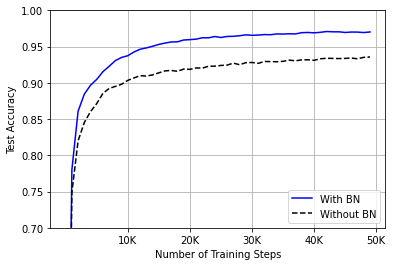

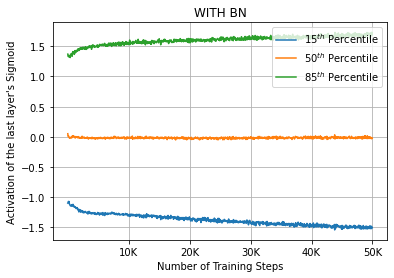

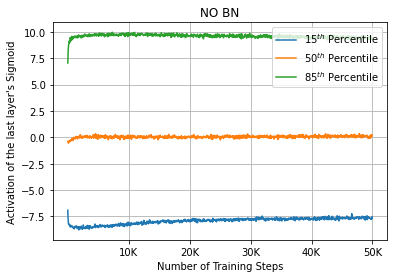

In [0]:
plt.figure()
plt.plot(testAccuracyPerTrainingStep, 'b', label='With BN')
plt.plot(testAccuracyPerTrainingStepNoBN, '--k', label='Without BN')
plt.xticks([10, 20, 30, 40, 50], ('10K', '20K', '30K', '40K', '50K'))
plt.xlabel('Number of Training Steps')
plt.ylabel('Test Accuracy')
plt.ylim(0.7, 1)
plt.legend()
plt.grid()
plt.savefig('Scratch_Accuracy_LR0-1_init1.png', dpi=200)
plt.show()

plt.figure()
plt.plot(sigmoidActivation15Percentile, label=r'$15^{th}$ Percentile')
plt.plot(sigmoidActivation50Percentile, label=r'$50^{th}$ Percentile')
plt.plot(sigmoidActivation85Percentile, label=r'$85^{th}$ Percentile')
plt.xticks([200, 400, 600, 800, 1000], ('10K', '20K', '30K', '40K', '50K'))
plt.xlabel('Number of Training Steps')
plt.ylabel("Activation of the last layer's Sigmoid")
plt.title("WITH BN")
plt.legend(loc='best')
plt.grid()
plt.savefig('Scratch_ActivationsBN_LR0-1_init1.png', dpi=200)
plt.show()

plt.figure()
plt.plot(sigmoidActivation15PercentileNoBN, label=r'$15^{th}$ Percentile')
plt.plot(sigmoidActivation50PercentileNoBN, label=r'$50^{th}$ Percentile')
plt.plot(sigmoidActivation85PercentileNoBN, label=r'$85^{th}$ Percentile')
plt.xticks([200, 400, 600, 800, 1000], ('10K', '20K', '30K', '40K', '50K'))
plt.xlabel('Number of Training Steps')
plt.ylabel("Activation of the last layer's Sigmoid")
plt.title("NO BN")
plt.legend(loc='best')
plt.grid()
plt.savefig('Scratch_ActivationsNoBN_LR0-1_init1.png', dpi=200)
plt.show()